<hr style="border:1px solid #FEC60D"> </hr>
<center><h1 style="color:#173F8A;"> FUNDAMENTOS MATEMATICOS PARA INTELIGENCIA ARTIFICIAL</h1></center> 
<center><h1 style="color:#173F8A;"> IMT 3850, 2023 </h1></center>
<hr style="border:1px solid #FEC60D"> </hr>
<center><h3 style="color:#0176DE;text-align:right;"> Profesor. Manuel A. Sanchez<br></h3></center>
<h3 style="color:#03122E;text-align:right;"> Magister en Inteligencia Artificial - MIA <br> Instituto de Ingenieria Matematica y Computacional - IMC<br>  Pontificia Universidad Catolica de Chile<br>   </h3>




<!-- Palette colors UC:
Primaria: 
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->

<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Algebra Lineal para IA - clase 3</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

<h1>Tabla de Contenidos<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#Ejemplo:-factorizacion-LU" data-toc-modified-id="">Ejemplo: Factorizacion LU
                </a>
            </span>
        </li>
    </ul>
    <ul class="toc-item">
        <li>
            <span>
                <a href="#Ejemplo:-PageRank" data-toc-modified-id="">Ejemplo: PageRank
                </a>
            </span>
        </li>
    </ul>
    <ul class="toc-item">
        <li>
            <span>
                <a href="#Ejemplo:-SVD" data-toc-modified-id="">Ejemplo: SVD
                </a>
            </span>
        </li>
    </ul>
    <ul class="toc-item">
        <li>
            <span>
                <a href="#Ejemplo:-PCA" data-toc-modified-id="">Ejemplo: PCA
                </a>
            </span>
        </li>
    </ul>
</div>

In [24]:
from numpy.random import rand, randint
from numpy import linspace, meshgrid
from matplotlib.pyplot import imshow, plot, axis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from PIL import Image
from scipy.linalg import lu
from IPython.display import display, HTML
display(HTML("""<style>.output {display: flex;align-items: center;text-align: center;}</style>"""))
np.set_printoptions(precision=4)

## Ejemplo: factorizacion LU

$$
A=\begin{bmatrix}
3 & 17 & 10 \\ 2 & 4 &-2 \\ 6 & 18 & -12
\end{bmatrix}
$$

In [2]:
A = np.array([[3,17,10],[2,4,-2],[6,18,-12]], dtype=np.float64)

# lu from scipy
P,L,U = lu(A)


In [3]:
print("Matriz de permutation:\n", P)
print("Matriz triangular inferior:\n", L)
print("Matriz triangular superior:\n",U)
print("A - PLU:\n", A - P@L@U)

Matriz de permutation:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
Matriz triangular inferior:
 [[ 1.      0.      0.    ]
 [ 0.5     1.      0.    ]
 [ 0.3333 -0.25    1.    ]]
Matriz triangular superior:
 [[  6.  18. -12.]
 [  0.   8.  16.]
 [  0.   0.   6.]]
A - PLU:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [22]:
def GEPP(A, b):
    '''
    Gaussian elimination with partial (row) pivoting
    input : A nonsingular and square matrix n x n 
            b vector n x 1
    output : x solution of the system A x = b
    '''
    # 1. Factorize A = PLU
    L, U, pT = LUPP(A)
    # 2. Solve P L U x = b
    Ptb = b[pT]
    # 3. Solve LUx = Pt b forward substitution
    y = forward_substitution(L, Ptb)
    # 4. Solve Ux = L^{-1} Pt b backward substitution
    x = backward_substitution(U,y)
    return x


def LUPP(Ainput):
    '''
    LU factorization with partial pivoting
    '''
    A = Ainput.copy()
    n = A.shape[0]
    pT = np.arange(0,n)
    for i in range(n-1):
        imax = abs(A[i:,i]).argmax() + i
        pT[[i,imax]] = pT[[imax,i]]
        if A[imax, i] == 0:
            raise ValueError("Matrix is singular.")
        elif imax != i:
            A[[i,imax],:] = A[[imax, i],:][:]
        A[(i+1):n,i][:] = (A[(i+1):n,i]/A[i,i])[:]
        A[(i+1):n, (i+1):n][:] = A[(i+1):n, (i+1):n]-np.outer(A[(i+1):n,i],A[i, (i+1):n])
    
    L = np.tril(A,-1)+np.eye(n)
    U = np.triu(A)
    return L, U, pT

def GE(A, b):
    '''
    Gaussian elimination without pivoting
    input : A nonsingular and square matrix n x n 
            b vector n x 1
    output : x solution of the system A x = b
    '''
    # 1. Factorize A = LU
    L, U = LU(A)
    # 2. Solve LUx = b forward substitution
    y = forward_substitution(L, b)
    # 3. Solve Ux = L^{-1} b backward substitution
    x = backward_substitution(U,y)
    return x


def LU(Ainput):
    '''
    LU factorization without pivoting
    '''
    A = Ainput.copy()
    n = A.shape[0]
    for i in range(n-1):
        if A[i, i] == 0:
            raise ValueError("coeficient is zero.")
        A[(i+1):n,i][:] = (A[(i+1):n,i]/A[i,i])[:]
        A[(i+1):n, (i+1):n][:] = A[(i+1):n, (i+1):n]-np.outer(A[(i+1):n,i],A[i, (i+1):n])
    
    L = np.tril(A,-1)+np.eye(n)
    U = np.triu(A)
    return L, U



def forward_substitution(L,b):
    '''
    Forward substitution algorithm for system L x = b
    input : L lower triangular matrix n x n
            b vector n x 1
    output: x solution of L x = b
    '''
    n = L.shape[0]
    x = np.zeros(n)
    x[0] = b[0]/L[0,0]
    for i in range(1,n):
        x[i] = (b[i] - L[i,0:i]@x[0:i])/L[i,i]
    return x

def backward_substitution(U,b):
    '''
    Backward substitution algorithm for system U x = b
    input : U upper tringular matrix n x n
            b vector n x 1
    output : x solution of U x = b
    '''
    n = U.shape[0]
    x = np.zeros(n)
    x[n-1] = b[n-1]/U[n-1,n-1]
    for i in range(n-2,-1,-1):
        x[i] = (b[i] - U[i,(i+1):n]@(x[(i+1):n]))/U[i,i]
    return x

## Ejemplo: sistema lineal con LU
Considere el sistema lineal $Ax = b$ con
\begin{equation}
A = 
\begin{pmatrix}
1 & 3 & 4 & 1 \\ 2 & 1 & 5 & 1 \\ 4 & 1 & 6 & 1 \\ 6 & 2 & 3 & 2
\end{pmatrix}
\qquad
b = 
\begin{pmatrix}
3\\2\\1\\3
\end{pmatrix}
\end{equation}

La solucion del sistema es
\begin{equation}
x= 
\begin{pmatrix}
-8/9\\0\\-1/9\\13/3
\end{pmatrix}
\end{equation}

In [25]:
A0 = np.array([[1,3,4,1],[2,1,5,1],[3,1,6,1],[6,2,3,2]],dtype=np.float64)
b0 = np.array([3,2,1,3], dtype=np.float64)
x_GEPP = GEPP(A0,b0)
x_GE = GE(A0,b0)
x_np = np.linalg.solve(A0,b0)
dferror = {'Errors:':['||x-xaprox||','||b-Axaprox||'], 'Gaussian Ellimination':[np.linalg.norm(x_np-x_GE), np.linalg.norm(b0-A0.dot(x_GE))], 'Gaussian Ellimination with PP':[np.linalg.norm(x_np-x_GEPP),  np.linalg.norm(b0-A0.dot(x_GEPP))]}
df = pd.DataFrame(data=dferror)
df

,Errors:,Gaussian Ellimination,Gaussian Ellimination with PP
0,||x-xaprox||,4.652682e-16,1.110223e-16
1,||b-Axaprox||,2.843558e-15,9.930137e-16


## Ejemplo: PageRank 

$$
A =
\begin{bmatrix}
0 & 0 & 1 & 1/2 \\ 1/3 & 0 & 0 & 0 \\ 1/3 & 1/2 & 0 & 1/2 \\ 1/3 & 1/2 & 0 & 0
\end{bmatrix}
$$

In [4]:
A = np.array([[0,0,1,1/2],[1/3,0,0,0],[1/3,1/2,0,1/2],[1/3,1/2,0,0]])

valores_propios, vectores_propios = np.linalg.eig(A)
lam = valores_propios[0].real
x = (vectores_propios[:,0]).real
print("valor propio :", lam)
print("vector propio:", x)


valor propio : 1.000000000000002
vector propio: [0.721  0.2403 0.5408 0.3605]


In [5]:
y = np.sum(x)
x = x*(1/y)
print("vector propio escalado:", x)
print("solucion              :",np.array([12/31,4/31,9/31,6/31]))

vector propio escalado: [0.3871 0.129  0.2903 0.1935]
solucion              : [0.3871 0.129  0.2903 0.1935]


## Ejemplo: SVD

## Descomposicion en valores singulares (SVD) para compresion de imagenes

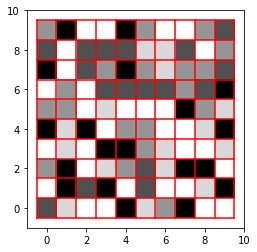

In [6]:
# define matrix
C = randint(5, size=(10, 10))

imshow(C, cmap='Greys', interpolation='none');
x = linspace(-.5,9.5,11); 
y = x;
[X,Y] = meshgrid(x,y);
plot(X.T,Y.T,'r');
plot(X,Y,'r');
axis('scaled');
axis([-1, 10, -1, 10]);

(10, 10)


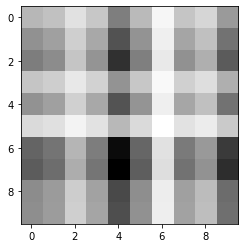

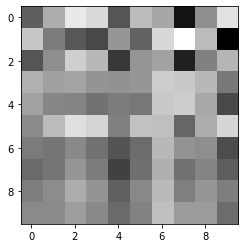

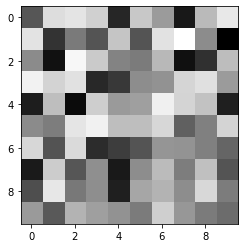

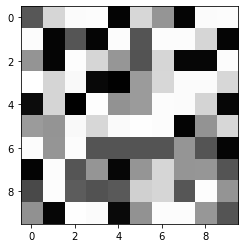

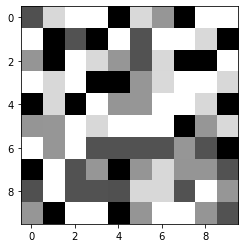

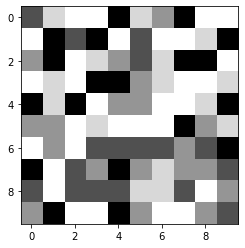

In [7]:
U, sigma, V = np.linalg.svd(C)
print(U.shape)
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='Greys');
plt.show()
reconstimg = np.matrix(U[:, :2]) * np.diag(sigma[:2]) * np.matrix(V[:2, :])
plt.imshow(reconstimg, cmap='Greys');
plt.show()
reconstimg = np.matrix(U[:, :4]) * np.diag(sigma[:4]) * np.matrix(V[:4, :])
plt.imshow(reconstimg, cmap='Greys');
plt.show()
reconstimg = np.matrix(U[:, :8]) * np.diag(sigma[:8]) * np.matrix(V[:8, :])
plt.imshow(reconstimg, cmap='Greys');
plt.show()
reconstimg = np.matrix(U[:, :11]) * np.diag(sigma[:11]) * np.matrix(V[:11, :])
plt.imshow(reconstimg, cmap='Greys');
plt.show()
imshow(C, cmap='Greys', interpolation='none');
plt.show()

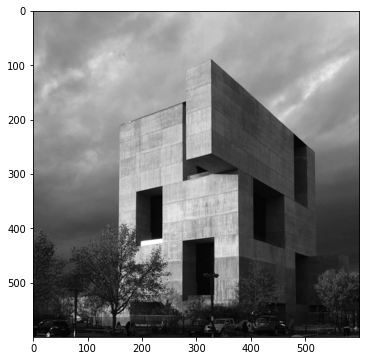

In [8]:
img = Image.open('edif_elemental.png')
imggray = img.convert('LA')
#plt.figure(figsize=(9, 6))
#plt.imshow(imggray);

# convert to matrix
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray');

In [9]:
U, sigma, V = np.linalg.svd(imgmat)

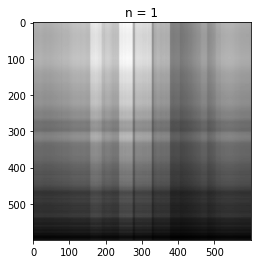

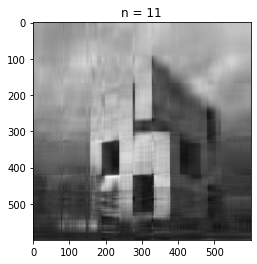

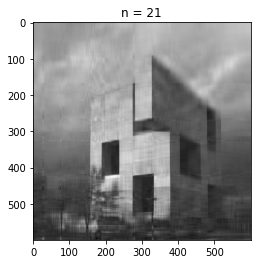

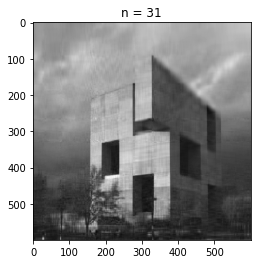

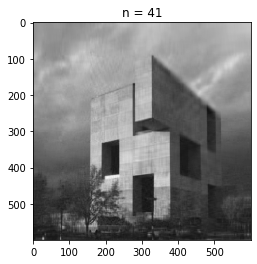

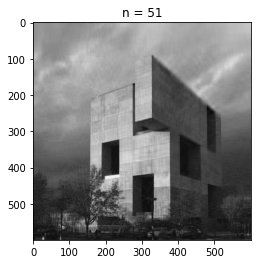

In [10]:
for i in range(1, 52, 10):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

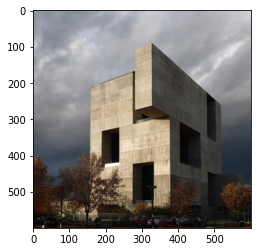

In [11]:
img = Image.open('edif_elemental.png');
imgRGB = img.convert('RGB')
imshow(imgRGB, interpolation='none');

# convert to matrix
#imgmat = np.array(list(imgRGB.getdata()), int)
imgmat = np.array(imgRGB)

plt.imshow(imgmat);
#imgmat = np.matrix(imgmat)
#print(imgmat)

In [12]:
Cred = imgmat[:,:,0]
Cgreen = imgmat[:,:,1]
Cblue = imgmat[:,:,2]

Ured, sigmared, Vred = np.linalg.svd(Cred)
Ugreen, sigmagreen, Vgreen = np.linalg.svd(Cgreen)
Ublue, sigmablue, Vblue = np.linalg.svd(Cblue)

U = np.zeros((Ured.shape[0], Ublue.shape[1],3));
U[:,:,0] = Ured;
U[:,:,1] = Ugreen;
U[:,:,2] = Ublue;

sigma = np.zeros((sigmared.shape[0],3));
sigma[:,0] = sigmared;
sigma[:,1] = sigmagreen;
sigma[:,2] = sigmablue;

V = np.zeros((Vred.shape[0], Vblue.shape[1],3));
V[:,:,0] = Vred;
V[:,:,1] = Vgreen;
V[:,:,2] = Vblue;

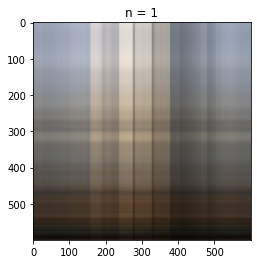

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


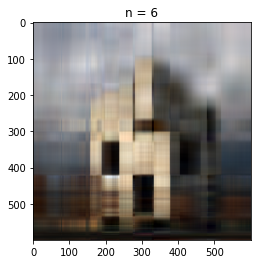

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


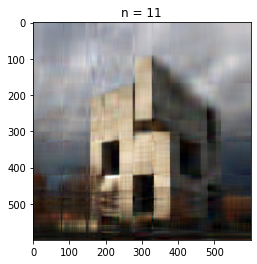

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


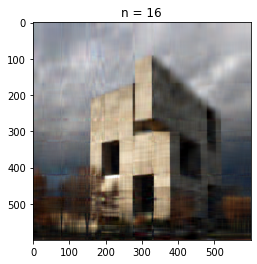

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


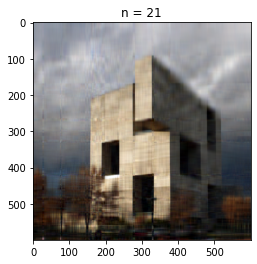

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


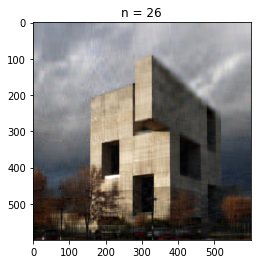

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


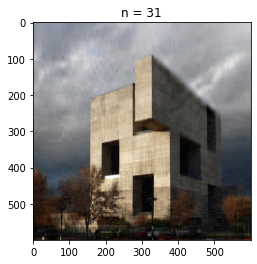

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


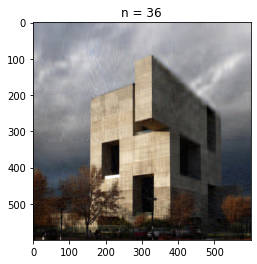

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


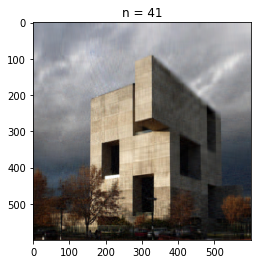

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


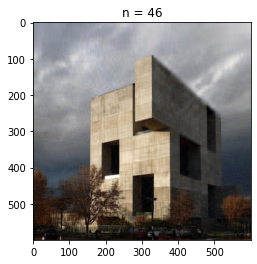

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


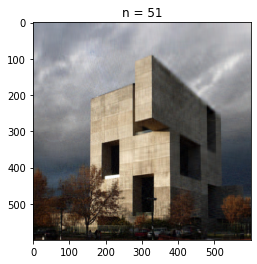

In [13]:
for n in range(1, 52, 5):
    reconstimg = np.zeros(imgmat.shape)
    for i in range(3):
        reconstimg[:,:,i] = (np.trunc(  np.matmul( U[:, :n,i], np.matmul(np.diag(sigma[:n,i]) , (V[:n, :,i]) ) ) ))

    #print(reconstimg)
    plt.imshow(reconstimg.astype(int))
    title = "n = %s" % n
    plt.title(title)
    plt.show()

## Ejemplo: PCA
## Principal Component Analysis

In [18]:
import idx2numpy
import numpy as np
import cv2
file = 'images-data/train-images-idx3-ubyte.idx3-ubyte'
arr = idx2numpy.convert_from_file(file)
arrnew = [arr_j.flatten() for arr_j in arr]
X = np.array(arrnew)
print(X.shape)

(60000, 784)


## pre procesamiento de los datos

In [19]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.99 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present
pca = PCA(variance)

pca.fit(X) #fit the data according to our PCA instance
print("Numero de componentes antes de PCA  = " + str(X.shape[1]))
print("Numero de componenets despues de PCA 0.99 = " + str(pca.n_components_)) 

Numero de componentes antes de PCA  = 784
Numero de componenets despues de PCA 0.99 = 331


In [20]:
Xnew = pca.transform(X)
print('Dimension de nuestros datos despues de PCA = ' + str(Xnew.shape))

Dimension de nuestros datos despues de PCA = (60000, 331)


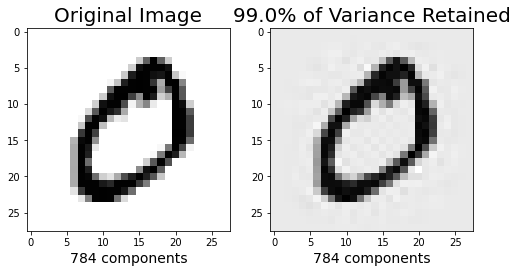

In [21]:
approximation = pca.inverse_transform(Xnew)
#image reconstruction using the less dimensioned data
plt.figure(figsize=(8,4));
n = 1 #index value, change to view different data
# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X[n].reshape(28, 28),
cmap=plt.cm.binary);
plt.xlabel(str(X.shape[1])+' components', fontsize = 14)
plt.title('Original Image', fontsize = 20);
# 196 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[n].reshape(28, 28),
 cmap=plt.cm.binary);
plt.xlabel(str(X.shape[1]) +' components', fontsize = 14)
plt.title(str(variance * 100) + '% of Variance Retained', fontsize = 20);

In [21]:
28*28


784